# 공통파일


In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
file_path_son = 'datathon_energy/'

train = pd.read_csv(file_path_son+'train.csv', encoding='cp949')
test = pd.read_csv(file_path_son+'test.csv', encoding='cp949')

#train = pd.read_csv('~/_Python/Exploration/data/energy/train.csv', encoding = "cp949")
#test = pd.read_csv('~/_Python/Exploration/data/energy/test.csv', encoding = "cp949")
train.columns = ['num', 'date', 'use_electric', 'temperature', 'wind_speed', 'humidity', 'precipitation', 'sunshine', 'operation', 'solar_power']
train['date']= pd.to_datetime(train['date'])


# 1. 데이타 분석

In [6]:
train.shape

(122400, 10)

In [7]:
train.head()

num                date  use_electric  temperature  wind_speed  humidity  \
0    1 2020-06-01 00:00:00      8179.056         17.6         2.5      92.0   
1    1 2020-06-01 01:00:00      8135.640         17.7         2.9      91.0   
2    1 2020-06-01 02:00:00      8107.128         17.5         3.2      91.0   
3    1 2020-06-01 03:00:00      8048.808         17.1         3.2      91.0   
4    1 2020-06-01 04:00:00      8043.624         17.0         3.3      92.0   

   precipitation  sunshine  operation  solar_power  
0            0.8       0.0        0.0          0.0  
1            0.3       0.0        0.0          0.0  
2            0.0       0.0        0.0          0.0  
3            0.0       0.0        0.0          0.0  
4            0.0       0.0        0.0          0.0

In [8]:
train.columns

Index(['num', 'date', 'use_electric', 'temperature', 'wind_speed', 'humidity',
       'precipitation', 'sunshine', 'operation', 'solar_power'],
      dtype='object')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num            122400 non-null  int64         
 1   date           122400 non-null  datetime64[ns]
 2   use_electric   122400 non-null  float64       
 3   temperature    122400 non-null  float64       
 4   wind_speed     122400 non-null  float64       
 5   humidity       122400 non-null  float64       
 6   precipitation  122400 non-null  float64       
 7   sunshine       122400 non-null  float64       
 8   operation      122400 non-null  float64       
 9   solar_power    122400 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 9.3 MB


In [10]:
train.describe()

num   use_electric    temperature     wind_speed  \
count  122400.000000  122400.000000  122400.000000  122400.000000   
mean       30.500000    2324.830866      24.251713       2.151641   
std        17.318173    2058.999326       3.407902       1.514475   
min         1.000000       0.000000      11.100000       0.000000   
25%        15.750000    1055.268000      21.800000       1.100000   
50%        30.500000    1700.352000      24.200000       1.900000   
75%        45.250000    2780.487000      26.500000       2.900000   
max        60.000000   17739.225000      36.300000      20.100000   

            humidity  precipitation       sunshine      operation  \
count  122400.000000  122400.000000  122400.000000  122400.000000   
mean       80.169848       0.514989       0.213533       0.683333   
std        15.525862       2.624505       0.370517       0.465178   
min        19.000000       0.000000       0.000000       0.000000   
25%        70.000000       0.000000       0.000000       0.000000   
50%        84.000000       0.000000       0.000000       1.000000   
75%        93.000000       0.000000       0.300000       1.000000   
max       100.000000      81.500000       1.000000       1.000000   

         solar_power  
count  122400.000000  
mean        0.483333  
std         0.499724  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

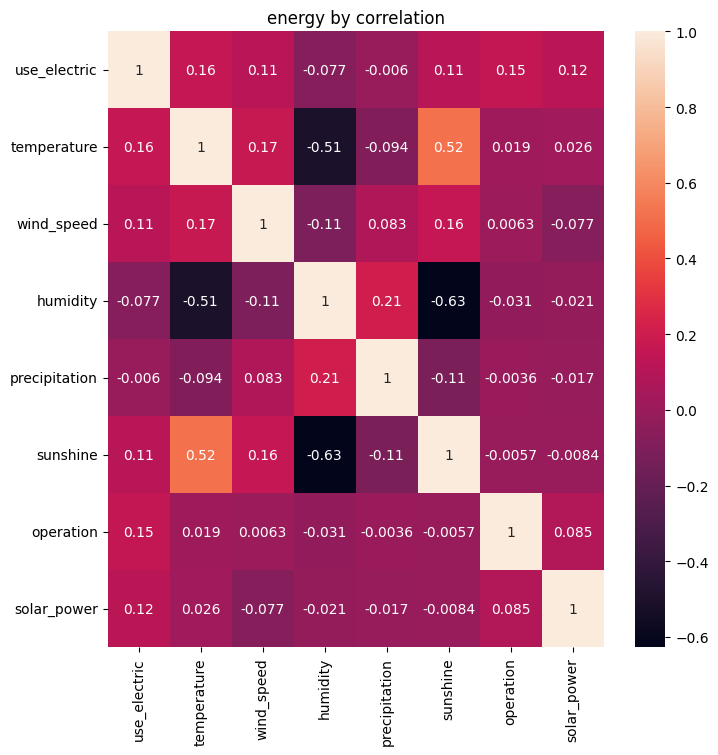

In [13]:
corr_df= train[['use_electric', 'date', 'temperature', 'wind_speed', 'humidity', 'precipitation', 'sunshine', 'operation', 'solar_power']]

# 한글 폰트 사용을 위해서 세팅
'''
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
'''

plt.figure(figsize=(8,8))

sns.heatmap(data=corr_df.corr(), annot=True)
plt.title('energy by correlation')
plt.show()


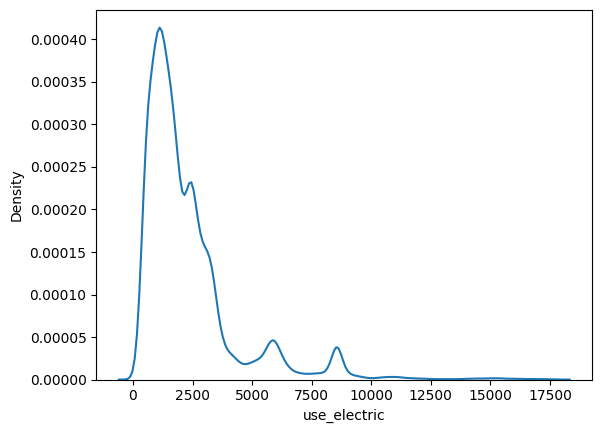

In [14]:
sns.kdeplot(data=train['use_electric'])
plt.show()

In [15]:
train['use_electric'].skew()  #왜도 : 분포가 대칭을 벗어나 치우친 정도

2.569979214229397

In [16]:
train['use_electric'].kurt()  # 첨도 : 뽀족한 정도

8.998589167827355

## feature 별 전력사용량과의 관계

In [20]:
# CATE_COLS = ['num', "mgrp", 'holiday', 'dow', 'cluster', 'hot', 'nelec_cool_flag', 'solar_flag']
# for col in CATE_COLS:
#     df[col] = df[col].astype(str).astype('category')





In [24]:
train.head()

num                date  use_electric  temperature  wind_speed  humidity  \
0    1 2020-06-01 00:00:00      8179.056         17.6         2.5      92.0   
1    1 2020-06-01 01:00:00      8135.640         17.7         2.9      91.0   
2    1 2020-06-01 02:00:00      8107.128         17.5         3.2      91.0   
3    1 2020-06-01 03:00:00      8048.808         17.1         3.2      91.0   
4    1 2020-06-01 04:00:00      8043.624         17.0         3.3      92.0   

   precipitation  sunshine  operation  solar_power  
0            0.8       0.0        0.0          0.0  
1            0.3       0.0        0.0          0.0  
2            0.0       0.0        0.0          0.0  
3            0.0       0.0        0.0          0.0  
4            0.0       0.0        0.0          0.0

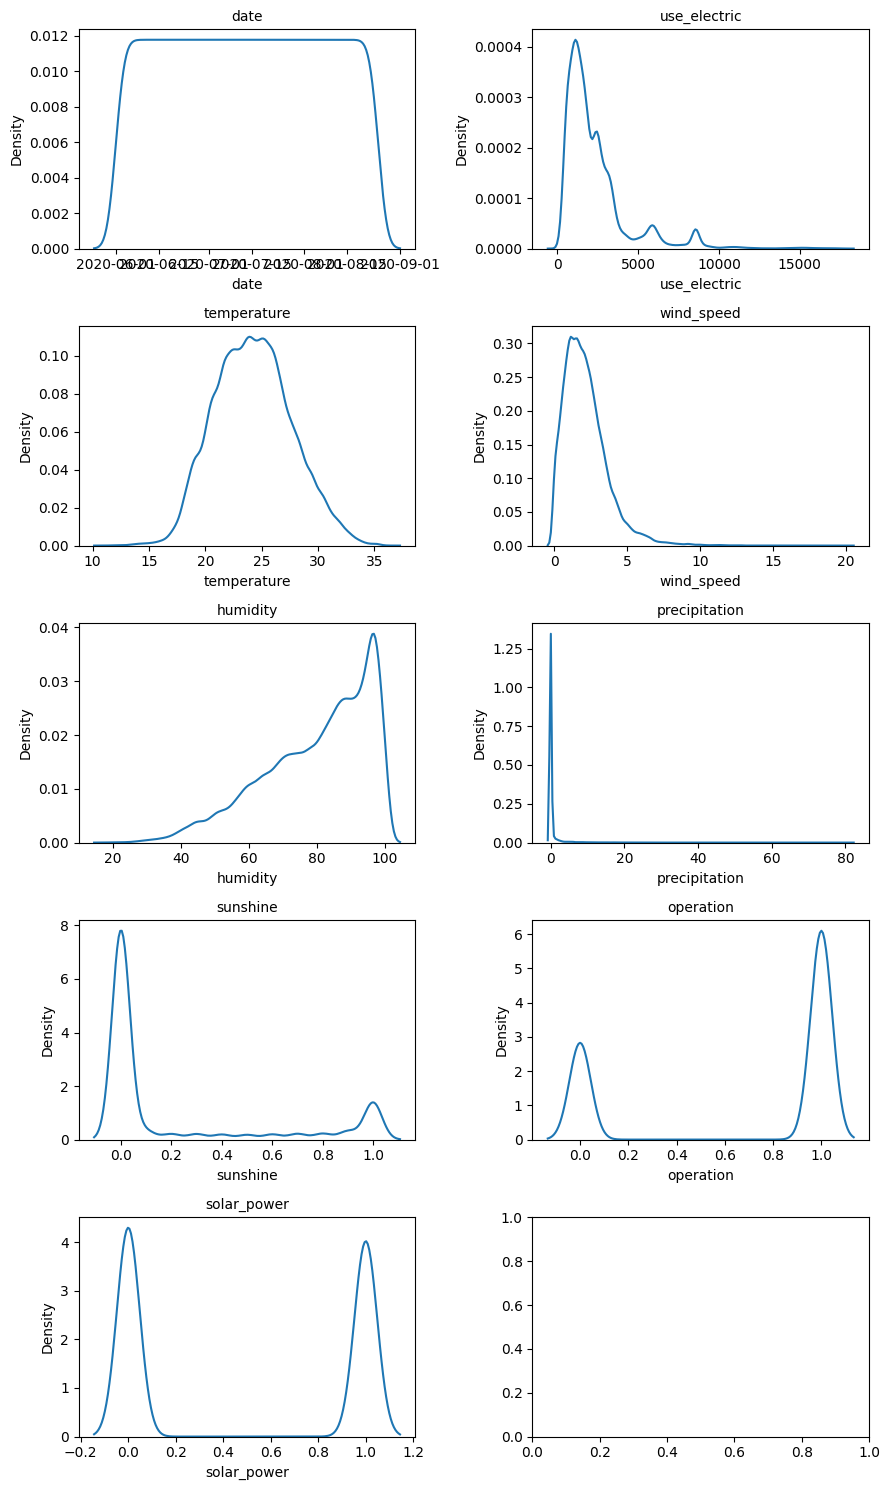

In [17]:
skew_columns = ['date', 'use_electric', 'temperature', 'wind_speed', 'humidity', 'precipitation', 'sunshine', 'operation', 'solar_power']

fig, ax = plt.subplots(5, 2, figsize=(9, 15), tight_layout=True)

count = 0
for row in range(5):
    for col in range(2):
        if count == 9:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col] )
        ax[row][col].set_title(skew_columns[count], fontsize=10)
        count += 1

In [ ]:
## 개별 컬럼 분석

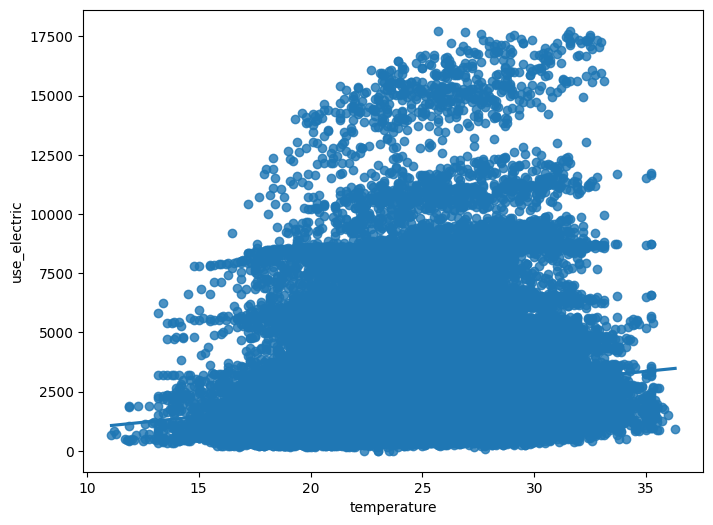

In [19]:
#'date', 'use_electric', 'temperature', 'wind_speed', 'humidity', 'precipitation', 'sunshine', 'operation', 'solar_power'

data = pd.concat([train['use_electric'], train['temperature']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='temperature', y="use_electric", data=data)

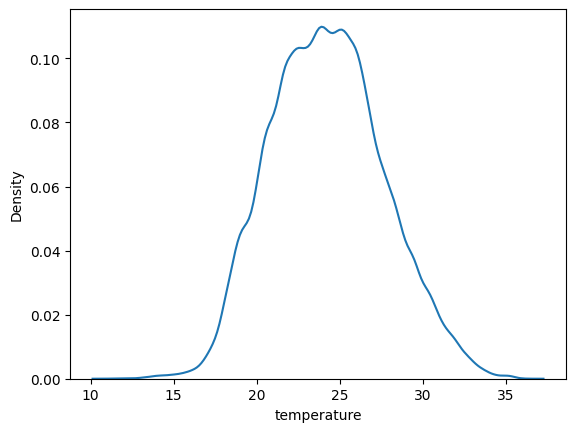

In [20]:
kde = sns.kdeplot(train['temperature'])

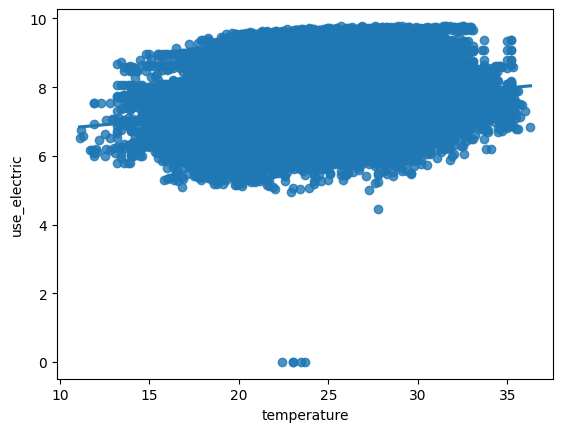

In [22]:
x,y = train['temperature'], np.log1p(train['use_electric'])


fig = sns.regplot(x=x,y=y)

# 2.모델링 전략 수립

# 3. 전처리

# 4. Normalization

# 5.모델링

# 6.하이퍼 파라미터 

# 7.훈련 및 예측 Blending

# 8. 파일 출력 및 제출

# 9.회고